# The Cropland Data Layer
### Exploring US Crop Production


### The Corn and Soybean Rotation

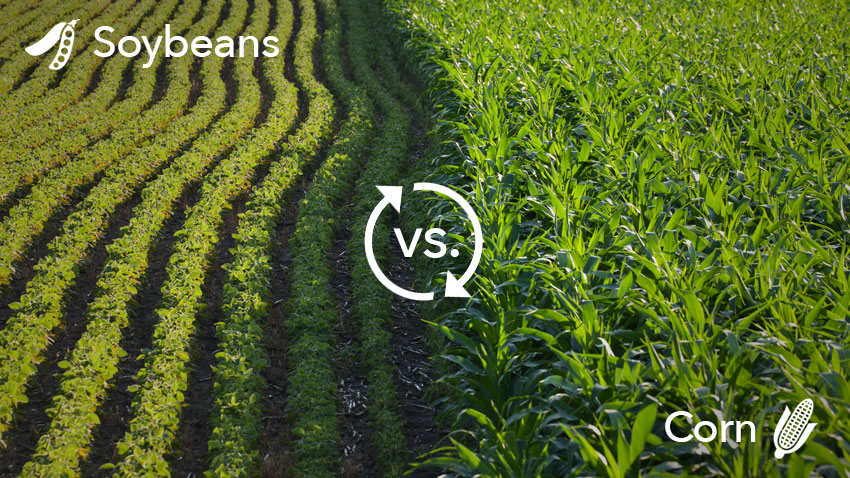

The most popular crop rotation pattern in Illinois because of the yield impacts:

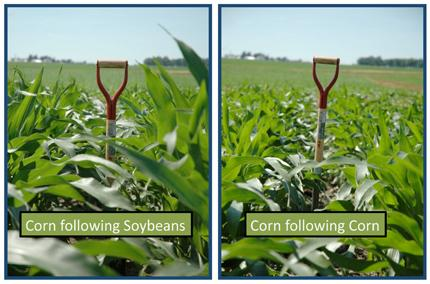

How can we visualize this in the data?

### Steps of the Analysis:
1. Read in shape files + raster files.
2. Clip files.
3. Describe Illinois land uses
4. Create crop rotation rasters.
5. Visualize rasters.
6. Merge in other data sources.

### The Import Line

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d

## 1. Read in Data

Read them in:

In [ ]:
data_dir="C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/2_Images/"

Rasters

In [ ]:
cdl_17 = rasterio.open(data_dir + "CDL_2017_clip.tif")
cdl_16 = rasterio.open(data_dir + "CDL_2016_clip.tif")

Shapefile

In [ ]:
country = geopandas.read_file(data_dir+"us_states.json")

Create a dictionary (just for FUN)

In [ ]:
cdls = {16:cdl_16,17:cdl_17}

### ahh, but did you remember to check the projection??

In [ ]:
cdl_17.crs == country.crs

They are not the same! So easiest thing is just to reproject the vector file to the raster's CRS

In [ ]:
# Reproject
country = country.to_crs(cdl_16.crs)

## 2. Clipping Files

Want just Continental US

In [ ]:
country = country[(country.NAME!="Alaska")&\
                  (country.NAME!="Hawaii")&\
                  (country.NAME!="Puerto Rico")]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(cdl_16, ax=ax)
country.plot(ax=ax, facecolor='none', edgecolor='black')

So we have a small window over Illinois, Indiana, Kentucky, and Ohio.

We just want Illinois, so we can do some clipping.

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
IL_coords = getFeatures(country[(country["NAME"] == "Illinois")])

img_out, img_transform = mask(cdl_16,IL_coords) 

In [ ]:
plt.imshow(img_out[0,:,:])

To save space, I'm actually going to cut off the right side of this raster

In [ ]:
plt.plot((img_out[0,:,:]!=0).sum(axis=0))

The non-zero pixels are basically to the left of 15k.

In [ ]:
plt.imshow(img_out[0,:,:15000])

Good enough.

There is, however, an easier way to do this... (__Hint: there's an argument I did not use__).

In [ ]:
for year,cdl in cdls.items():
    for k,v in coords.items():
        # Transform with the mask
        img_out, img_transform = mask(cdl,v) 
        
        # Cut out the right side of the image.
        img_out = img_out[:,:,:15000]
        
        # Metadata
        out_meta = cdl.meta.copy()
        out_meta['height'] = img_out.shape[1]
        out_meta['width'] = img_out.shape[2]
        out_meta['transform'] = img_transform
        
        # This field will tell you which pixel values mean "no data" and thus are transparent.
        out_meta['nodata'] = 0
        
        with rasterio.open("./raster_"+k+"_"+str(year)+".tif", "w", **out_meta) as dest:
            dest.write(img_out)

Now let's see if we did it right

In [ ]:
IL_16 = rasterio.open("./raster_IL_16.tif")

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
rasterio.plot.show(IL_16, ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')

Things are missing from the edges because they are zero values, or "background" according to the CDL documentation/

## 3. Top 10 Land Uses in Each Year

To find the names for the pixels, I made a dictionary (json file) from the CDL documentation. In your homework, you will want to create something similar.

In [ ]:
with open("CDL_dict.json") as f:
    pixel_names = json.load(f)[0]

Now we store all the rasters in one dictionary:

In [ ]:
rasters = {}
for year in cdls.keys():
    rasters[year] = {}
    for state in coords.keys():
        rasters[year][state] = rasterio.open("./raster_"+state+"_"+str(year)+".tif")

Let's look at one example:

In [ ]:
r17_array = rasters[17]['IL'].read(1)
pixels = pd.Series(r17_array.flatten())
pixels = pixels[pixels!=0]

pixel_counts = pixels.value_counts()
pixel_counts.head(10)

But what do these mean?

Here is where the dictionary comes in handy:

In [ ]:
# Extract the pixel labels
pixel_ixs = pd.Series(pixel_counts.index).astype(str)

# You can feed a dictionary to "replace"
pixel_counts.index = pixel_ixs.replace(pixel_names)

# Reindex the df
pixel_counts.head(10)

How much is that? Let's find the percentage.

In [ ]:
# Method 1:
(pixel_counts/pixel_counts.sum()*100).head(10)

Had I used the "normalize" argument, I could have done it when I called "value counts"

In [ ]:
# Method 2:
pixel_counts = pixels.value_counts(normalize=True)*100

pixel_ixs = pd.Series(pixel_counts.index).astype(str)

pixel_counts.index = pixel_ixs.replace(pixel_names)

pixel_counts.head(10)

So 31% of our land mass is corn, 27% forest, 15% forest, and the rest other things.

Visualizing with a pie chart is possible, but can be a bit awkward given how many labels there are:

In [ ]:
pixel_counts.plot(kind="pie")

Solutions?

Condense some of these categories:

In [ ]:
condensed_counts = pixel_counts.iloc[:4]
condensed_counts.loc["Other"] = pixel_counts.iloc[4:].sum()
condensed_counts.plot(kind="pie")

We could also try and label things under the "Other" category better:

In [ ]:
# Which ixs have "developed" in the title?
Developed = ["Developed" in x for x in list(pixel_counts.index)]

# Create a df with index as a column
pixel_counts_wix = pixel_counts.reset_index()

# Replace ixs with the word "developed" in them with just the label "Developed"
pixel_counts_wix.loc[Developed,"index"] = "Developed"

# Groupby each label, sum the pixels, and sort.
pixel_counts = pixel_counts_wix.groupby("index").sum()[0].sort_values(ascending=False)

In [ ]:
condensed_counts = pixel_counts.iloc[:5]
condensed_counts.loc["Other"] = pixel_counts.iloc[4:].sum()
condensed_counts.plot(kind="pie",autopct='%1.1f%%')

So above the tables are in units of percentage of land each year.

Mostly just corn, soybeans, and forest.

## 4. Making Crop Rasters

Here I wrote a function that does the write and transform tasks necessary to transform and array into a raster.

In [ ]:
def recode_raster_binary(raster,array,img_transform,name):
    out_meta = raster.meta.copy()
    array = array[np.newaxis,:,:]
    out_meta['height'] = array.shape[1]
    out_meta['width'] = array.shape[2]
    out_meta['transform'] = img_transform
    
    with rasterio.open(name, "w", **out_meta) as dest:
        dest.write(array.astype(rasterio.uint8)) # Notice here it codes "uint8" because thats all we need for binary data

Using the documentation, we know that these are the two codes for corn and soybeans:

In [ ]:
crop_labels = {1:"corn",5:"soybeans"}

Below is a nested for loop that creates a nested dictionary with these rasters:

In [ ]:
crop_rasters = {}

# For each state
for state in coords.keys():
    crop_rasters[state] = {}
    # For each CDL year:
    for year in cdls.keys():
        crop_rasters[state][year] = {}
        # For each crop:
        for val,crop in crop_labels.items():
            # Read in the band and make a binary array:
            array = (rasters[year][state].read(1)==val).astype(np.int8)
            
            # Write it out using our function
            recode_raster_binary(cdl,array,img_transform,"./raster_"+state+"_"+str(year)+"_"+crop+".tif")

            # Store it in this dictionary:
            crop_rasters[state][year][crop] = rasterio.open("./raster_"+state+"_"+str(year)+"_"+crop+".tif")

Now plot it:

In [ ]:
# Make some colormaps first:

cmap_beans = matplotlib.colors.ListedColormap(['white',"C0"])
cmap_corn = matplotlib.colors.ListedColormap(['white',"darkgreen"])

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10, 15))

# Corn 2016
rasterio.plot.show(crop_rasters["IL"][16]["corn"], ax=ax[0,0],cmap=cmap_corn)
ax[0,0].set_title("Corn Area, 2016")
country[country['NAME']=="Illinois"].plot(ax=ax[0,0], facecolor='none', edgecolor='black')

# Soybeans 2016
rasterio.plot.show(crop_rasters["IL"][16]["soybeans"], ax=ax[0,1],cmap=cmap_beans)
ax[0,1].set_title("Soybean Area, 2016")
country[country['NAME']=="Illinois"].plot(ax=ax[0,1], facecolor='none', edgecolor='black')

# Corn 2017
rasterio.plot.show(crop_rasters["IL"][17]["corn"], ax=ax[1,0],cmap=cmap_corn)
ax[1,0].set_title("Corn Area, 2017")
country[country['NAME']=="Illinois"].plot(ax=ax[1,0], facecolor='none', edgecolor='black')

# Soybeans 2017
rasterio.plot.show(crop_rasters["IL"][17]["soybeans"], ax=ax[1,1],cmap=cmap_beans)
ax[1,1].set_title("Soybean Area, 2017")
country[country['NAME']=="Illinois"].plot(ax=ax[1,1], facecolor='none', edgecolor='black')

### How do we determine crop rotation?

What we want to know is how often a pixel changed from being a 1 to a 5 and vice versa, and also how often did it stay the same.

There are two ways to do this. One is the REALLY LONG way: go through each index and assign a 1 or a 2 to anything monocropped or rotated.

What's the __vectorized__ way?

Since we are comparing pixels in the same location but in different years, we can do an element by element comparison. Is the pixel corn in one year and corn the next? Is the pixel soybeans in one year and corn the next? etc.

In [ ]:
# Its very useful to make matrices like this that are three dimensions.
# Each line here reads raster, gives it a new first axis
# The outer code concatenates them on the new first axis to make them 3D arrays.
IL_17 = np.concatenate([rasterio.open("./raster_IL_17_corn.tif").read(1)[np.newaxis,:,:], 
                        rasterio.open("./raster_IL_17_soybeans.tif").read(1)[np.newaxis,:,:]],axis=0) 

IL_16 = np.concatenate([rasterio.open("./raster_IL_16_corn.tif").read(1)[np.newaxis,:,:],
                        rasterio.open("./raster_IL_16_soybeans.tif").read(1)[np.newaxis,:,:]],axis=0)

Here I'm going to assess a boolean condition about the rasters, multiplying them by the number I want them to be.

In [ ]:
# Assign a one to anything monocropped
corn_to_corn = ((IL_17[0,:,:]==1)&(IL_16[0,:,:]==1))*1
beans_to_beans = ((IL_17[1,:,:]==1)&(IL_16[1,:,:]==1))*1

# Assign a two to anything that rotated
beans_to_corn = ((IL_17[0,:,:]==1)&(IL_16[1,:,:]==1))*2
corn_to_beans = ((IL_17[1,:,:]==1)&(IL_16[0,:,:]==1))*2

Assuming all these categories are mutually exclusive, we can just add them all together:

In [ ]:
Rotated = corn_to_corn + beans_to_beans + beans_to_corn + corn_to_beans

Everything not in those categories will be zero.

So what percent of the pixels were rotated between corn and soybeans?

In [ ]:
rotated_pixels = pd.Series(Rotated.flatten())

rotated_pixels[rotated_pixels!=0].value_counts(normalize=True)*100

Nearly 80% of soybeans and corn is rotated between the two.

Visualizing what we just created:

In [ ]:
# First put it in a raster format:
recode_raster_binary(cdl_16,Rotated,img_transform,"./raster_IL_rotation.tif")

Rotated_Raster = rasterio.open("./raster_IL_rotation.tif")

Next make a colormap:

In [ ]:
labels = {1:"Non-Rotated",
          2:"Rotated"}

cmap = matplotlib.colors.ListedColormap(['white', "C3","C0"])

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

Now plot them together

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(Rotated_Raster,cmap=cmap,ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')
plt.legend(handles=patches,fontsize=16)
plt.axis('off')

### What about the different types of rotation?

In [ ]:
# As before:
corn_to_corn = ((IL_17[0,:,:]==1)&(IL_16[0,:,:]==1))*1
beans_to_beans = ((IL_17[1,:,:]==1)&(IL_16[1,:,:]==1))*2
beans_to_corn = ((IL_17[0,:,:]==1)&(IL_16[1,:,:]==1))*3
corn_to_beans = ((IL_17[1,:,:]==1)&(IL_16[0,:,:]==1))*4

In [ ]:
Rotated_Cats = corn_to_corn + beans_to_beans + beans_to_corn + corn_to_beans

__FYI: the long, for loop way would be:__

In [ ]:
for i in range(Rotation.shape[0]):
    for j in range(Rotation.shape[1]):
        if (IL_17[0,i,j]==1)&(IL_16[0,i,j]==1):
            Rotation[i,j] = 1
        elif (IL_17[1,i,j]==1)&(IL_16[1,i,j]==1):
            Rotation[i,j] = 2
        elif (IL_17[0,i,j]==1)&(IL_16[1,i,j]==1):
            Rotation[i,j] = 3
        elif (IL_17[1,i,j]==1)&(IL_16[0,i,j]==1):
            Rotation[i,j] = 4

__Don't run this code unless you want your computer to busy for days.__

Writing out the array in a raster format:

In [ ]:
recode_raster_binary(cdl_16,Rotated_Cats,img_transform,"./raster_IL_rotation_cats.tif")

Rotated_Cat_Raster = rasterio.open("./raster_IL_rotation_cats.tif")

## 5. Visualizing the Crop Rotation Raster

In [ ]:
cmap = matplotlib.colors.ListedColormap(['white',"C3","C0","C1",'lightblue'])

labels = {1:"Corn to Corn",
          2:"Beans to Beans",
          3:"Beans to Corn",
          4:"Corn to Beans"}

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(Rotated_Cat_Raster,cmap=cmap,ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')
plt.legend(handles=patches,fontsize=12,loc=(0,.8))
plt.axis('off')

In table form:

In [ ]:
Rotated_Series = pd.Series(Rotated_Cats.flatten())

top_transitions = Rotated_Series[Rotated_Series!=0].value_counts(normalize=True)*100

labels = {"1":"Corn to Corn",
          "2":"Beans to Beans",
          "3":"Beans to Corn",
          "4":"Corn to Beans"}

top_transitions.index = pd.Series(top_transitions.index).astype(str).replace(labels)

top_transitions

Not surprisingly, crop rotation is equally split between corn and beans (nearly). About 20\% of pixels did not rotate, mostly in the North or South of the state.

## 6. Other Data Sources

Suppose we wanted to answer the question "what impact does crop rotation have on crop yield?"

### How might we go about answering this question? 
### Discuss in groups!

Recall that most yield data would be at the county level in our case.